---

This script implements a Gurobi-based bi-objective optimization model that assigns technicians to farmers for buffalo artificial insemination services while minimizing total travel distance and straw usage from the central office. It considers technician capacity, straw logistics, load balancing, and farmer preferences.

---


This model uses gurobipy to solve the bi-objective optimization problem.

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 28.6 MB/s eta 0:00:00


---
To demonstrate the solution of the bi-objective optimization problem, we use a sample network consisting of 12 nodes (representing the office, technicians, and farmers) interconnected by 20 edges. Since the input is provided as an edge-based distance matrix, we compute the full node-to-node distance matrix using Dijkstra’s algorithm.

---

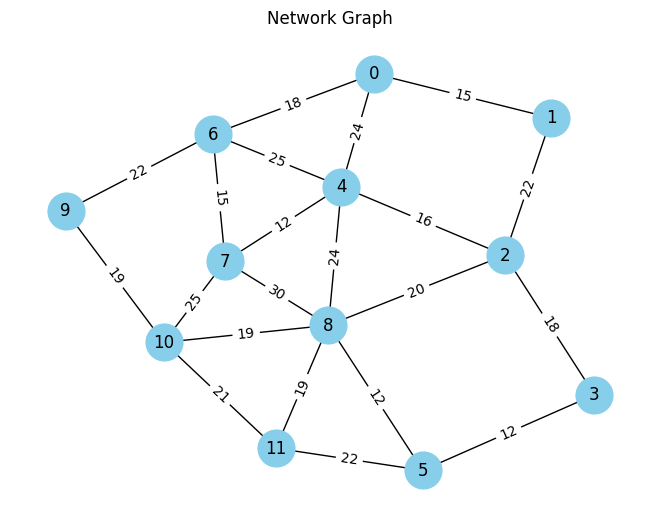

Dijkstra Shortest Path Distance Matrix:

[[ 0. 15. 37. 55. 24. 60. 18. 33. 48. 40. 58. 67.]
 [15.  0. 22. 40. 38. 52. 33. 48. 42. 55. 61. 61.]
 [37. 22.  0. 18. 16. 30. 41. 28. 20. 58. 39. 39.]
 [55. 40. 18.  0. 34. 12. 59. 46. 24. 62. 43. 34.]
 [24. 38. 16. 34.  0. 36. 25. 12. 24. 47. 37. 43.]
 [60. 52. 30. 12. 36.  0. 57. 42. 12. 50. 31. 22.]
 [18. 33. 41. 59. 25. 57.  0. 15. 45. 22. 40. 61.]
 [33. 48. 28. 46. 12. 42. 15.  0. 30. 37. 25. 46.]
 [48. 42. 20. 24. 24. 12. 45. 30.  0. 38. 19. 19.]
 [40. 55. 58. 62. 47. 50. 22. 37. 38.  0. 19. 40.]
 [58. 61. 39. 43. 37. 31. 40. 25. 19. 19.  0. 21.]
 [67. 61. 39. 34. 43. 22. 61. 46. 19. 40. 21.  0.]]


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Edge-based distance matrix
distance= np.array([
    [0, 15, 0, 0, 24, 0, 18, 0, 0, 0, 0, 0],
    [15, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 22, 0, 18, 16, 0, 0, 0, 20, 0, 0, 0],
    [0, 0, 18, 0, 0, 12, 0, 0, 0, 0, 0, 0],
    [24, 0, 16, 0, 0, 0, 25, 12, 24, 0, 0, 0],
    [0, 0, 0, 12, 0, 0, 0, 0, 12, 0, 0, 22],
    [18, 0, 0, 0, 25, 0, 0, 15, 0, 22, 0, 0],
    [0, 0, 0, 0, 12, 0, 15, 0, 30, 0, 25, 0],
    [0, 0, 20, 0, 24, 12, 0, 30, 0, 0, 19, 19],
    [0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 19, 0],
    [0, 0, 0, 0, 0, 0, 0, 25, 19, 19, 0, 21],
    [0, 0, 0, 0, 0, 22, 0, 0, 19, 0, 21, 0]
])

def plot_graph(distance_matrix):
    G = nx.Graph()

    # Add nodes to the graph
    n = len(distance_matrix)
    G.add_nodes_from(range(n))

    # Add edges to the graph with weights from the distance matrix
    for i in range(n):
        for j in range(n):
            if distance_matrix[i][j] != 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    # Draw the graph
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Network Graph")
    plt.show()

plot_graph(distance)
G = nx.Graph()
n = distance.shape[0]

for i in range(n):
    for j in range(n):
        if distance[i, j] > 0:
            G.add_edge(i, j, weight=distance[i, j])

# Compute Dijkstra all-pairs shortest path distance matrix
distance_full = np.zeros((n, n))

for i in range(n):
    lengths = nx.single_source_dijkstra_path_length(G, i, weight='weight')
    for j in range(n):
        if j in lengths:
            distance_full[i, j] = lengths[j]
        else:
            distance_full[i, j] = np.inf

# Print the distance matrix
np.set_printoptions(precision=1, suppress=True)
print("Dijkstra Shortest Path Distance Matrix:\n")
print(distance_full)


---
### **Objective**

The goal of the model is to **minimize two things simultaneously**:

1. The **total travel distance** between technicians and the farmers they are assigned to.
2. The **total number of straws** that technicians need to refill from the central office.

These two objectives are combined using weights, allowing flexibility in prioritizing either distance or straw usage.

---

###  **Constraints**

1. **Each farmer must be assigned to exactly one technician.**
   No farmer is left unassigned, and each farmer can only have one technician.

2. **Technicians can only handle a limited number of farmers.**
   Each technician has a maximum number of farmers they are allowed to serve.

3. **Technicians must have enough straws to serve their assigned farmers.**
   The total number of straws they carry (initial supply + refilled from the office) must be at least equal to the number of farmers assigned to them.

4. **The total number of straws taken from the office is limited.**
   There is a maximum number of straws available for refilling at the central office.

5. **Farmer workload should be balanced across technicians.**
   The number of farmers assigned to each technician should be roughly equal, allowing a difference of at most one.

6. **Farmer preferences are respected (if given).**
   If a farmer has a preferred technician, the model enforces that preference, as long as the technician is available.

  ---



This is the first sample problem (without farmer preference) used to demonstrate the model. The key elements are as follows:

* **Technicians:** Nodes 4 and 8 are designated as AI technicians.
* **Farmers:** Nodes 0, 2, 3, 5, 6, 7, 9, 10, and 11 represent farmers that need to be assigned to a technician.
* **Office:** Node 1 serves as the central office or semen bank, where technicians can refill their straws.
* **Technician limits:** Each technician can serve up to 5 farmers (`tech_limits`).
* **Carrying capacity:** Technician 4 starts with 2 straws, and Technician 8 starts with 1 straw (`carrying_straws`).
* **Farmer preferences:** Currently empty (`farmer_preferences = {}`), indicating no explicit technician preferences from farmers.
* **Total straws available:** A maximum of 12 straws can be refilled from the office (`total_straws_available`).



In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Inputs
technicians = [4, 8]
farmers = [0, 2, 3, 5, 6, 7, 9, 10,11]
office = 1
tech_limits = {4: 5, 8: 5}
carrying_straws = {4: 2, 8: 1}
farmer_preferences = {}
total_straws_available = 12


# Weights for bi-objective
weight_distance = 1
weight_straws = 1

# Model
model = gp.Model("BiObjective_Tech_Assignment")

# Decision variables
x = model.addVars(farmers, technicians, vtype=GRB.BINARY, name="assign")
straws_from_office = model.addVars(technicians, vtype=GRB.INTEGER, name="refill")

# Objective: weighted sum of total distance + straw use
model.setObjective(
    weight_distance * gp.quicksum(distance_full[i][j] * x[i, j] for i in farmers for j in technicians) +
    weight_straws * gp.quicksum(straws_from_office[j] for j in technicians),
    GRB.MINIMIZE
)

# Constraints

# 1. Each farmer assigned to one technician
for i in farmers:
    model.addConstr(gp.quicksum(x[i, j] for j in technicians) == 1)

# 2. Technician capacity
for j in technicians:
    model.addConstr(gp.quicksum(x[i, j] for i in farmers) <= tech_limits[j])

# 3. Straw requirement per technician
for j in technicians:
    model.addConstr(carrying_straws[j] + straws_from_office[j] >= gp.quicksum(x[i, j] for i in farmers))

# 4. Total office straws constraint
model.addConstr(gp.quicksum(straws_from_office[j] for j in technicians) <= total_straws_available)

# 5. Load balancing (±1 farmer)
avg_farmers = len(farmers) // len(technicians)
for j in technicians:
    model.addConstr(gp.quicksum(x[i, j] for i in farmers) >= avg_farmers - 1)
    model.addConstr(gp.quicksum(x[i, j] for i in farmers) <= avg_farmers + 1)

# 6. Enforce farmer preferences
for farmer, preferred_tech in farmer_preferences.items():
    if preferred_tech in technicians:
        # Assign to preferred technician
        model.addConstr(x[farmer, preferred_tech] == 1, name=f"prefer_f{farmer}_t{preferred_tech}")
        for other_tech in technicians:
            if other_tech != preferred_tech:
                model.addConstr(x[farmer, other_tech] == 0, name=f"exclude_f{farmer}_t{other_tech}")
    else:
        # Fallback: assign to closest technician
        closest_tech = min(technicians, key=lambda t: distance_full[farmer, t])
        model.addConstr(x[farmer, closest_tech] == 1, name=f"fallback_f{farmer}_t{closest_tech}")
        for other_tech in technicians:
            if other_tech != closest_tech:
                model.addConstr(x[farmer, other_tech] == 0, name=f"exclude_f{farmer}_t{other_tech}_fallback")

# Solve
model.setParam("OutputFlag", 0)
model.optimize()

if model.status == GRB.OPTIMAL:
    print("\n✅ Optimal Assignment and Straw Distribution:")

    tech_farmer_count = {j: 0 for j in technicians}
    tech_farmer_list = {j: [] for j in technicians}
    tech_distances = {j: [] for j in technicians}

    for i in farmers:
        for j in technicians:
            if x[i, j].X > 0.5:
                dist = distance_full[i, j]
                print(f"Farmer {i} → Technician {j} | Distance: {dist:.1f}")
                tech_farmer_count[j] += 1
                tech_farmer_list[j].append(i)
                tech_distances[j].append(dist)

    print("\n📊 Technician Summary:")
    for j in technicians:
        assigned = tech_farmer_count[j]
        assigned_farmers = tech_farmer_list[j]
        refill = int(straws_from_office[j].X)
        carrying = carrying_straws[j]
        total_straws = carrying + refill
        total_dist = sum(tech_distances[j])
        print(f"Technician {j}:")
        print(f"  - Assigned farmers : {assigned} → {assigned_farmers}")
        print(f"  - Total distance    : {total_dist:.1f}")
        print(f"  - Carrying straws   : {carrying}")
        print(f"  - Office refill     : {refill}")
        print(f"  - Total straws      : {total_straws}\n")

    total_refilled = sum(straws_from_office[j].X for j in technicians)
    print(f"Total straws distributed from office: {int(total_refilled)} / {total_straws_available}")

    print("\n🔍 Verifying Preference Assignments After Optimization:")
    for farmer, preferred_tech in farmer_preferences.items():
        assigned_tech = None
        for tech in technicians:
            if x[farmer, tech].X > 0.5:
                assigned_tech = tech
                break
        if assigned_tech == preferred_tech:
            print(f"Farmer {farmer}: ✅ Assigned to preferred Technician {preferred_tech}")
        else:
            print(f"Farmer {farmer}: ⚠️ Preferred Technician {preferred_tech} not available → Assigned to Closest Technician {assigned_tech}")
else:
    print("❌ No optimal solution found.")


✅ Optimal Assignment and Straw Distribution:
Farmer 0 → Technician 4 | Distance: 24.0
Farmer 2 → Technician 4 | Distance: 16.0
Farmer 3 → Technician 8 | Distance: 24.0
Farmer 5 → Technician 8 | Distance: 12.0
Farmer 6 → Technician 4 | Distance: 25.0
Farmer 7 → Technician 4 | Distance: 12.0
Farmer 9 → Technician 8 | Distance: 38.0
Farmer 10 → Technician 8 | Distance: 19.0
Farmer 11 → Technician 8 | Distance: 19.0

📊 Technician Summary:
Technician 4:
  - Assigned farmers : 4 → [0, 2, 6, 7]
  - Total distance    : 77.0
  - Carrying straws   : 2
  - Office refill     : 2
  - Total straws      : 4

Technician 8:
  - Assigned farmers : 5 → [3, 5, 9, 10, 11]
  - Total distance    : 112.0
  - Carrying straws   : 1
  - Office refill     : 4
  - Total straws      : 5

Total straws distributed from office: 6 / 12

🔍 Verifying Preference Assignments After Optimization:



---

This visualization plots the network of farmers, technicians, and the office using NetworkX and Matplotlib. The nodes are connected based on the non-zero entries in the distance matrix, with edge labels showing the corresponding distances.

* Nodes with the same color represent farmers assigned to the same technician.
* Technician nodes share the same color as their assigned farmers.
* The office node is colored gray to distinguish it from technician-assigned groups.
* A legend is included to indicate each technician’s color, and a spring layout is used for better spacing and clarity.

---

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_graph(distance_matrix, assigned_farmers, color_map):
    G = nx.Graph()
    n = len(distance_matrix)
    G.add_nodes_from(range(n))

    # Add edges with distances
    for i in range(n):
        for j in range(i+1, n):
            if distance_matrix[i][j] != 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    # Assign node colors based on technician assignment
    node_colors = []
    for node in G.nodes():
        color = 'lightgray'
        for tech, farmers in assigned_farmers.items():
            if node == tech or node in farmers:
                color = color_map.get(tech, 'gray')
                break
        node_colors.append(color)

    # Layout and drawing
    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Technician {t}',
               markerfacecolor=color_map[t], markersize=10)
        for t in assigned_farmers
    ]
    plt.legend(handles=legend_elements, loc='upper left')
    plt.title("Network Graph Colored by Technician Assignment")
    plt.axis('off')
    plt.show()

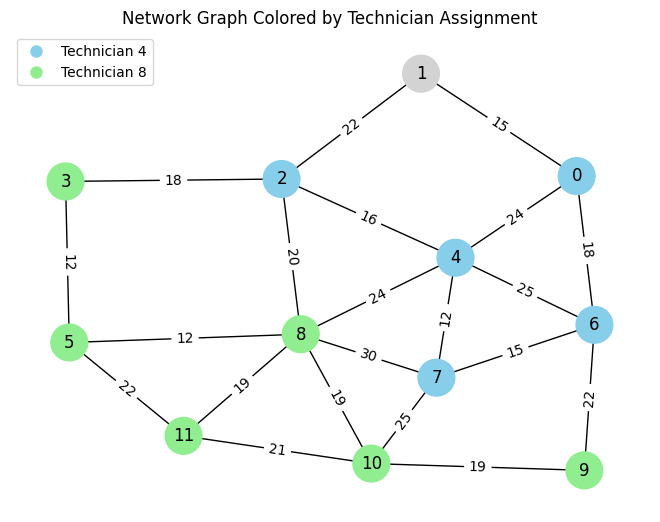

In [ ]:
plot_graph(distance, tech_farmer_list, {
    4: 'skyblue',
    8: 'lightgreen',
})


This is the second sample problem (with farmer preference) used to test the model. The key elements are:

* **Technicians:** Nodes 0, 4, and 5 are designated as AI technicians.
* **Farmers:** Nodes 1, 2, 3, 6, 7, 9, 10, and 11 require insemination services.
* **Office:** Node 8 serves as the central office or semen bank where technicians can refill their straws.
* **Technician limits:** Each technician can serve up to 5 farmers (`tech_limits`).
* **Carrying capacity:** All technicians begin with 1 straw each (`carrying_straws`).
* **Straw availability:** A total of 12 straws are available at the office for refill (`total_straws_available`).
* **Farmer preferences:**

  * Farmer 1 and Farmer 7 prefer Technician 4.
  * Farmer 3 prefers Technician 10 (note: Technician 10 is not in the current technician list, so the model will assign the closest technician instead).


In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Inputs
technicians = [0, 4,5]
farmers = [1, 2, 3, 6, 7, 9, 10,11]
office = 8
tech_limits = {0: 5, 4: 5, 5:5}
carrying_straws = {0: 1, 4: 1, 5:1}
total_straws_available = 12
farmer_preferences = {1: 4, 7: 4, 3:10}

# Weights for bi-objective
weight_distance = 1
weight_straws = 1

# Model
model = gp.Model("BiObjective_Tech_Assignment")

# Decision variables
x = model.addVars(farmers, technicians, vtype=GRB.BINARY, name="assign")
straws_from_office = model.addVars(technicians, vtype=GRB.INTEGER, name="refill")

# Objective: weighted sum of total distance + straw use
model.setObjective(
    weight_distance * gp.quicksum(distance_full[i][j] * x[i, j] for i in farmers for j in technicians) +
    weight_straws * gp.quicksum(straws_from_office[j] for j in technicians),
    GRB.MINIMIZE
)

# Constraints

# 1. Each farmer assigned to one technician
for i in farmers:
    model.addConstr(gp.quicksum(x[i, j] for j in technicians) == 1)

# 2. Technician capacity
for j in technicians:
    model.addConstr(gp.quicksum(x[i, j] for i in farmers) <= tech_limits[j])

# 3. Straw requirement per technician
for j in technicians:
    model.addConstr(carrying_straws[j] + straws_from_office[j] >= gp.quicksum(x[i, j] for i in farmers))

# 4. Total office straws constraint
model.addConstr(gp.quicksum(straws_from_office[j] for j in technicians) <= total_straws_available)

# 5. Load balancing
avg_farmers = len(farmers) // len(technicians)
for j in technicians:
    model.addConstr(gp.quicksum(x[i, j] for i in farmers) >= avg_farmers - 1)
    model.addConstr(gp.quicksum(x[i, j] for i in farmers) <= avg_farmers + 1)

# 6. Enforce farmer preferences
for farmer, preferred_tech in farmer_preferences.items():
    if preferred_tech in technicians:
        # Assign to preferred technician
        model.addConstr(x[farmer, preferred_tech] == 1, name=f"prefer_f{farmer}_t{preferred_tech}")
        for other_tech in technicians:
            if other_tech != preferred_tech:
                model.addConstr(x[farmer, other_tech] == 0, name=f"exclude_f{farmer}_t{other_tech}")
    else:
        # Fallback: assign to closest technician
        closest_tech = min(technicians, key=lambda t: distance_full[farmer, t])
        model.addConstr(x[farmer, closest_tech] == 1, name=f"fallback_f{farmer}_t{closest_tech}")
        for other_tech in technicians:
            if other_tech != closest_tech:
                model.addConstr(x[farmer, other_tech] == 0, name=f"exclude_f{farmer}_t{other_tech}_fallback")

# Solve
model.setParam("OutputFlag", 0)
model.optimize()

if model.status == GRB.OPTIMAL:
    print("\n✅ Optimal Assignment and Straw Distribution:")

    tech_farmer_count = {j: 0 for j in technicians}
    tech_farmer_list = {j: [] for j in technicians}
    tech_distances = {j: [] for j in technicians}

    for i in farmers:
        for j in technicians:
            if x[i, j].X > 0.5:
                dist = distance_full[i, j]
                print(f"Farmer {i} → Technician {j} | Distance: {dist:.1f}")
                tech_farmer_count[j] += 1
                tech_farmer_list[j].append(i)
                tech_distances[j].append(dist)

    print("\n📊 Technician Summary:")
    for j in technicians:
        assigned = tech_farmer_count[j]
        assigned_farmers = tech_farmer_list[j]
        refill = int(straws_from_office[j].X)
        carrying = carrying_straws[j]
        total_straws = carrying + refill
        total_dist = sum(tech_distances[j])
        print(f"Technician {j}:")
        print(f"  - Assigned farmers : {assigned} → {assigned_farmers}")
        print(f"  - Total distance    : {total_dist:.1f}")
        print(f"  - Carrying straws   : {carrying}")
        print(f"  - Office refill     : {refill}")
        print(f"  - Total straws      : {total_straws}\n")

    total_refilled = sum(straws_from_office[j].X for j in technicians)
    print(f"Total straws distributed from office: {int(total_refilled)} / {total_straws_available}")

    print("\n🔍 Verifying Preference Assignments After Optimization:")
    for farmer, preferred_tech in farmer_preferences.items():
        assigned_tech = None
        for tech in technicians:
            if x[farmer, tech].X > 0.5:
                assigned_tech = tech
                break
        if assigned_tech == preferred_tech:
            print(f"Farmer {farmer}: ✅ Assigned to preferred Technician {preferred_tech}")
        else:
            print(f"Farmer {farmer}: ⚠️ Preferred Technician {preferred_tech} not available → Assigned to Closest Technician {assigned_tech}")
else:
    print("❌ No optimal solution found.")


✅ Optimal Assignment and Straw Distribution:
Farmer 1 → Technician 4 | Distance: 38.0
Farmer 2 → Technician 4 | Distance: 16.0
Farmer 3 → Technician 5 | Distance: 12.0
Farmer 6 → Technician 0 | Distance: 18.0
Farmer 7 → Technician 4 | Distance: 12.0
Farmer 9 → Technician 0 | Distance: 40.0
Farmer 10 → Technician 5 | Distance: 31.0
Farmer 11 → Technician 5 | Distance: 22.0

📊 Technician Summary:
Technician 0:
  - Assigned farmers : 2 → [6, 9]
  - Total distance    : 58.0
  - Carrying straws   : 1
  - Office refill     : 1
  - Total straws      : 2

Technician 4:
  - Assigned farmers : 3 → [1, 2, 7]
  - Total distance    : 66.0
  - Carrying straws   : 1
  - Office refill     : 2
  - Total straws      : 3

Technician 5:
  - Assigned farmers : 3 → [3, 10, 11]
  - Total distance    : 65.0
  - Carrying straws   : 1
  - Office refill     : 2
  - Total straws      : 3

Total straws distributed from office: 5 / 12

🔍 Verifying Preference Assignments After Optimization:
Farmer 1: ✅ Assigned to 

In this sample problem, Farmer 3 prefers Technician 10, but since Technician 10 is not part of the available technician set ([0, 4, 5]), the model automatically assigns Farmer 3 to the closest available technician.

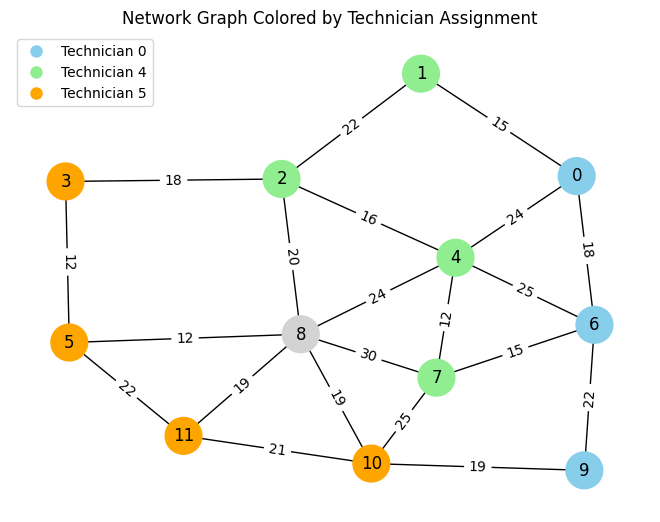

In [ ]:
plot_graph(distance, tech_farmer_list, {
    0: 'skyblue',
    4: 'lightgreen',
    5: 'orange',
})